## Library Import

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60
%matplotlib inline

Autosaving every 60 seconds


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix 
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import numpy as np 
import xgboost as xgb
from xgboost import plot_importance

from pprint import pprint

from utils import get_features_labels_from_data, split_data_into_train_validation, scale_dataframe, drop_columns_from_dataframe

## Let's learn about our data first

In [22]:
churn_data_train = pd.read_csv('churn_dataset_train.csv')
churn_data_test = pd.read_csv('churn_dataset_test.csv')

In [4]:
# See first few rows of train data
churn_data_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,AR,173,area_code_408,no,no,0,154.6,81,26.28,147.3,100.0,12.52,132.9,99,5.98,6.9,5,1.86,0,no
1,ID,127,area_code_408,no,no,0,102.8,128,17.48,143.7,95.0,12.21,191.4,97,8.61,10.0,5,2.70,1,no
2,TX,91,area_code_415,no,no,0,251.5,57,42.76,179.1,113.0,15.22,163.2,72,7.34,6.6,3,1.78,1,no
3,ND,60,area_code_510,no,no,0,203.2,99,NaN,235.8,131.0,20.04,224.9,112,10.12,15.1,6,4.08,2,no
4,NV,83,area_code_510,no,yes,31,129.8,87,22.07,183.4,110.0,15.59,169.4,40,7.62,14.3,6,3.86,1,no


In [5]:
churn_data_train['area_code'].value_counts()

area_code_415    1721
area_code_408     894
area_code_510     885
Name: area_code, dtype: int64

In [6]:
churn_data_train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3500.000000,3500.000000,3500.000000,3500.000000,3216.000000,3500.000000,3269.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,100.062286,7.654857,180.133229,99.821429,30.643193,200.012857,100.109208,17.001297,199.786514,99.714286,8.990494,10.284829,4.470286,2.777434,1.553714
std,40.126972,13.430216,53.946041,19.841249,9.147634,50.504487,20.023304,4.292901,49.987834,20.025978,2.249460,2.777536,2.497207,0.749906,1.315906
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.700000,87.000000,24.480000,165.800000,87.000000,14.090000,167.000000,86.000000,7.520000,8.600000,3.000000,2.320000,1.000000
50%,100.000000,0.000000,180.150000,100.000000,30.620000,199.900000,100.000000,16.990000,199.300000,99.500000,8.970000,10.400000,4.000000,2.810000,1.000000
75%,127.000000,16.000000,216.125000,113.000000,36.725000,233.900000,114.000000,19.880000,233.325000,113.000000,10.500000,12.100000,6.000000,3.270000,2.000000
max,232.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## Visualize data distrubution across all columns

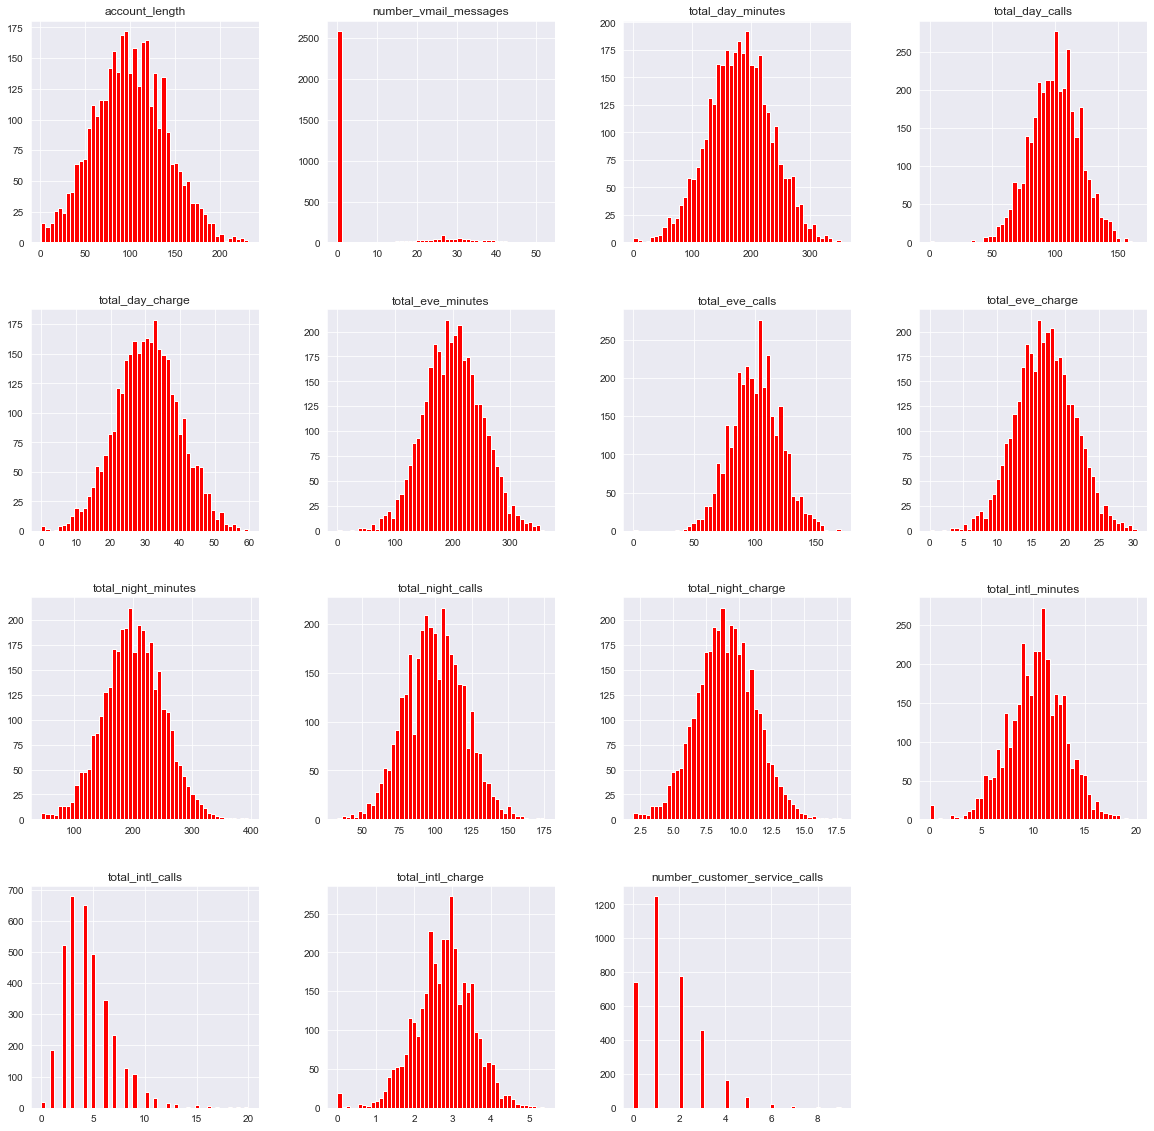

In [7]:
sns.set_style('dark')
churn_data_train.hist(bins=50,figsize=(20,20),color='red');

## Find out if we have any NULL or NaN values

In [8]:
NaN_columns = churn_data_train.columns[churn_data_train.isna().any()].tolist()
print(f"NaN columns: {NaN_columns}")

NaN columns: ['total_day_charge', 'total_eve_calls']


In [9]:
rows_with_NaN = churn_data_train.isna().any(axis=1)
NaN_rows = churn_data_train[rows_with_NaN]
NaN_rows[NaN_columns]

,total_day_charge,total_eve_calls
3,NaN,131.0
6,NaN,NaN
15,30.62,NaN
20,26.84,NaN
21,NaN,133.0
...,...,...
3458,30.26,NaN
3465,34.95,NaN
3475,NaN,115.0
3494,25.65,NaN


## Data distribution of NaN columns before imputting 

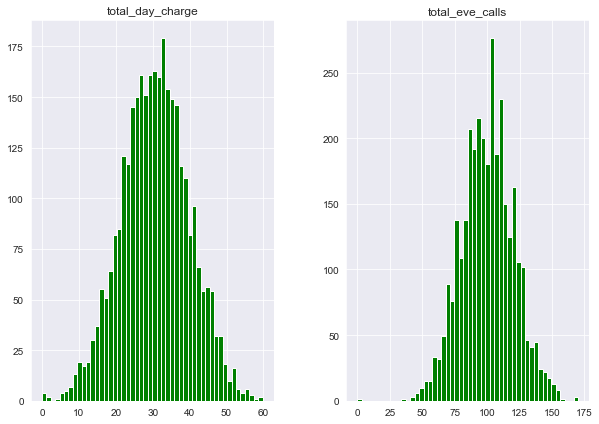

In [10]:
churn_data_train[NaN_columns].hist(bins=50,figsize=(10,7),color='green');

### Lets try different imputing techniques

In [11]:
## Let's fill the NaN values with mean, median and normal distribution values for both columns
temp_df = churn_data_train.copy()

mu1, sigma1 = temp_df['total_day_charge'].mean(), temp_df['total_day_charge'].std()
temp_df['total_day_charge_normal_dist'] = temp_df['total_day_charge'].fillna(np.random.normal(mu1, sigma1))
temp_df['total_day_charge_mean'] = temp_df['total_day_charge'].fillna(temp_df['total_day_charge'].mean())
temp_df['total_day_charge_median'] = temp_df['total_day_charge'].fillna(temp_df['total_day_charge'].median())

mu2, sigma2 = temp_df['total_eve_calls'].mean(), temp_df['total_eve_calls'].std()
temp_df['total_eve_calls_normal_dist'] = temp_df['total_eve_calls'].fillna(np.random.normal(mu2, sigma2))
temp_df['total_eve_calls_mean'] = temp_df['total_eve_calls'].fillna(temp_df['total_eve_calls'].mean())
temp_df['total_eve_calls_median'] = temp_df['total_eve_calls'].fillna(temp_df['total_eve_calls'].median())

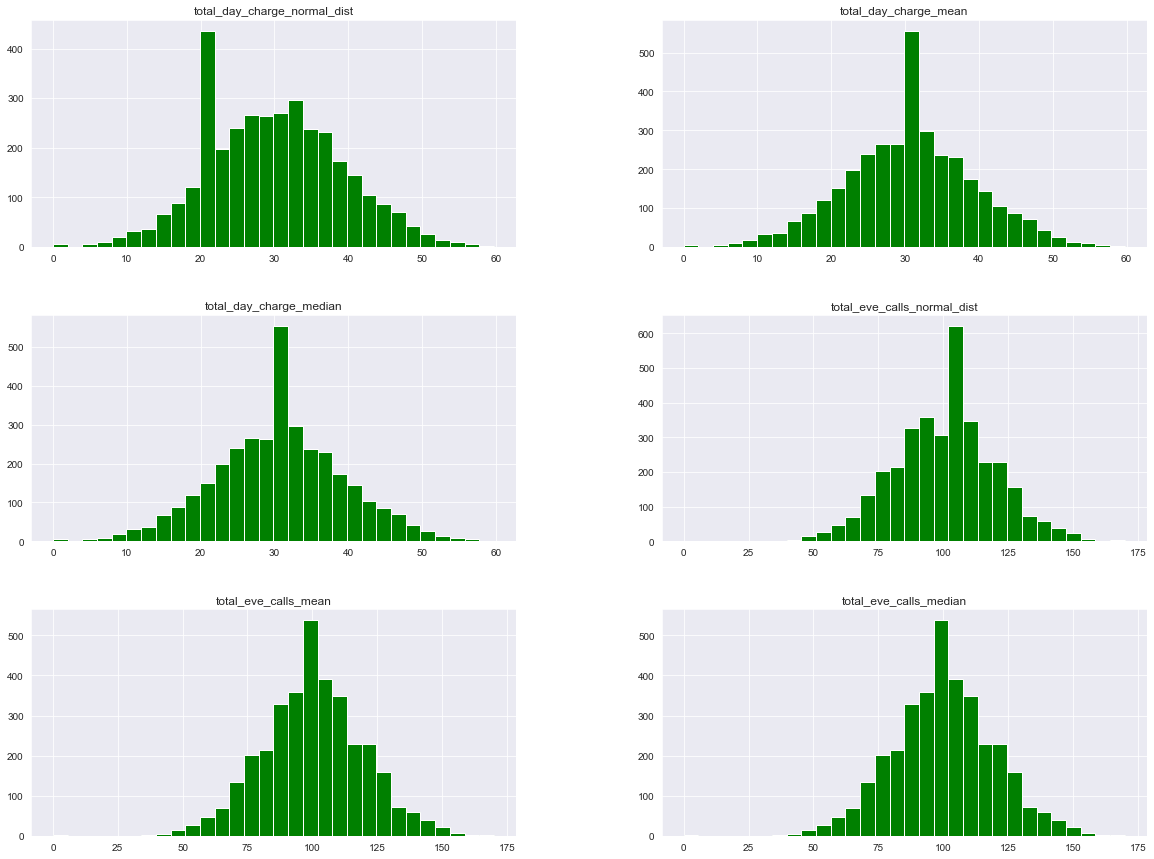

In [12]:
temp_df[['total_day_charge_normal_dist', 'total_day_charge_mean', 'total_day_charge_median',
        'total_eve_calls_normal_dist', 'total_eve_calls_mean', 'total_eve_calls_median']].hist(bins=30,figsize=(20,15), color='green');


## From the above graph, it might be a good idea to impute mean values in place of NaNs. 

In [23]:
churn_data_train['total_day_charge'].fillna(churn_data_train['total_day_charge'].mean(), inplace=True)
churn_data_train['total_eve_calls'].fillna(churn_data_train['total_eve_calls'].mean(), inplace=True)

## Data distribution of NaN columns before imputting 

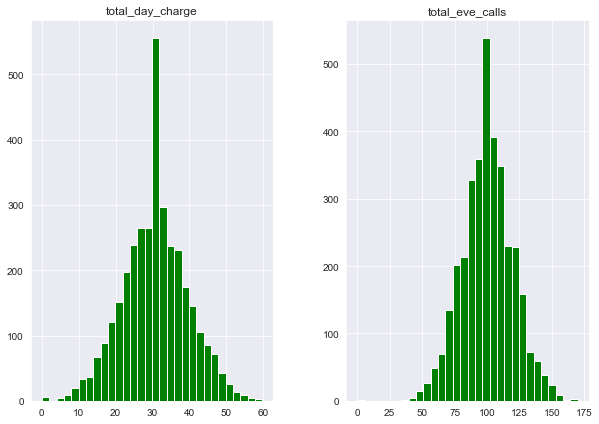

In [24]:
churn_data_train[NaN_columns].hist(bins=30, figsize=(10,7), color='green');

In [25]:
## Verify last time if we have any null values left in dataset
churn_data_train.columns[churn_data_train.isna().any()].tolist()

[]

## Let's check types of our columns

In [16]:
churn_data_train.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                  float64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

### We have few categorical columns which we have to take care of.

In [17]:
# Find out categorical columns
categorical_columns = churn_data_train.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']

In [18]:
churn_data_train.select_dtypes(include = 'object').head()

,state,area_code,international_plan,voice_mail_plan,churn
0,AR,area_code_408,no,no,no
1,ID,area_code_408,no,no,no
2,TX,area_code_415,no,no,no
3,ND,area_code_510,no,no,no
4,NV,area_code_510,no,yes,no


In [19]:
churn_data_train['area_code'].unique()

array(['area_code_408', 'area_code_415', 'area_code_510'], dtype=object)

In [20]:
## Verify if we see similar area codes in test data
churn_data_test['area_code'].unique()

array(['area_code_408', 'area_code_510', 'area_code_415'], dtype=object)

In [26]:
## Convert categorical column type to categorical type and assign an index to each unique value
print("Processing training data..\n\n")
# churn_data_train.state = pd.Categorical(churn_data_train.state).codes
# churn_data_train.area_code = pd.Categorical(churn_data_train.area_code).codes
churn_data_train.international_plan = pd.Categorical(churn_data_train.international_plan).codes
churn_data_train.voice_mail_plan = pd.Categorical(churn_data_train.voice_mail_plan).codes
churn_data_train.churn = pd.Categorical(churn_data_train.churn).codes
churn_data_train = pd.get_dummies(churn_data_train, columns=['state', 'area_code'])

print("Processing testing data.. but without churn column..")
# churn_data_test.state = pd.Categorical(churn_data_test.state).codes
# churn_data_test.area_code = pd.Categorical(churn_data_test.area_code).codes
churn_data_test.international_plan = pd.Categorical(churn_data_test.international_plan).codes
churn_data_test.voice_mail_plan = pd.Categorical(churn_data_test.voice_mail_plan).codes
churn_data_test = pd.get_dummies(churn_data_test, columns=['state', 'area_code'])

Processing training data..


Processing testing data.. but without churn column..


In [27]:
churn_data_train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,173,0,0,0,154.6,81,26.280000,147.3,100.0,12.52,...,0,0,0,0,0,0,0,1,0,0
1,127,0,0,0,102.8,128,17.480000,143.7,95.0,12.21,...,0,0,0,0,0,0,0,1,0,0
2,91,0,0,0,251.5,57,42.760000,179.1,113.0,15.22,...,0,0,0,0,0,0,0,0,1,0
3,60,0,0,0,203.2,99,30.643193,235.8,131.0,20.04,...,0,0,0,0,0,0,0,0,0,1
4,83,0,1,31,129.8,87,22.070000,183.4,110.0,15.59,...,0,0,0,0,0,0,0,0,0,1


In [28]:
churn_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 3500 non-null   int64  
 1   international_plan             3500 non-null   int8   
 2   voice_mail_plan                3500 non-null   int8   
 3   number_vmail_messages          3500 non-null   int64  
 4   total_day_minutes              3500 non-null   float64
 5   total_day_calls                3500 non-null   int64  
 6   total_day_charge               3500 non-null   float64
 7   total_eve_minutes              3500 non-null   float64
 8   total_eve_calls                3500 non-null   float64
 9   total_eve_charge               3500 non-null   float64
 10  total_night_minutes            3500 non-null   float64
 11  total_night_calls              3500 non-null   int64  
 12  total_night_charge             3500 non-null   f

In [29]:
churn_data_train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,173,0,0,0,154.6,81,26.280000,147.3,100.0,12.52,...,0,0,0,0,0,0,0,1,0,0
1,127,0,0,0,102.8,128,17.480000,143.7,95.0,12.21,...,0,0,0,0,0,0,0,1,0,0
2,91,0,0,0,251.5,57,42.760000,179.1,113.0,15.22,...,0,0,0,0,0,0,0,0,1,0
3,60,0,0,0,203.2,99,30.643193,235.8,131.0,20.04,...,0,0,0,0,0,0,0,0,0,1
4,83,0,1,31,129.8,87,22.070000,183.4,110.0,15.59,...,0,0,0,0,0,0,0,0,0,1


## After data processing, let's look at data distribution again

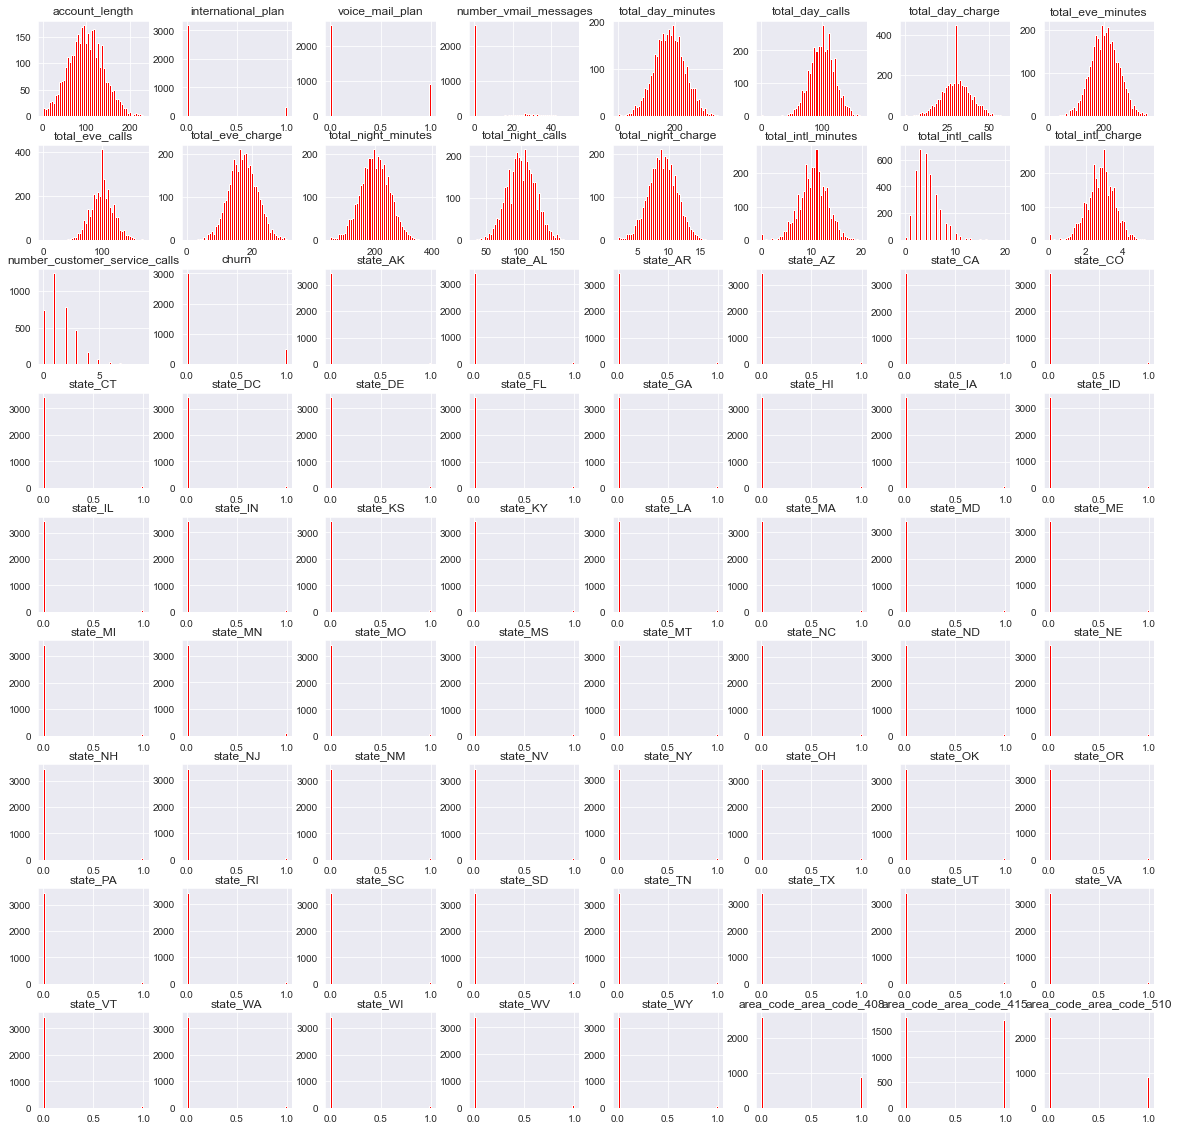

In [305]:
sns.set_style('dark')
churn_data_train.hist(bins=20,figsize=(20,20),color='red');

## How does our class distribution look like?

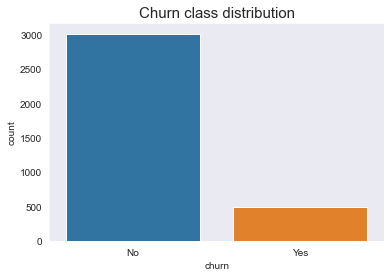

In [30]:
ax = sns.countplot(x='churn', data=churn_data_train);
ax.set_xticklabels(["No", "Yes"]);
ax.set_title("Churn class distribution", fontsize=15);

### Let's find out how data distribution for features for each class

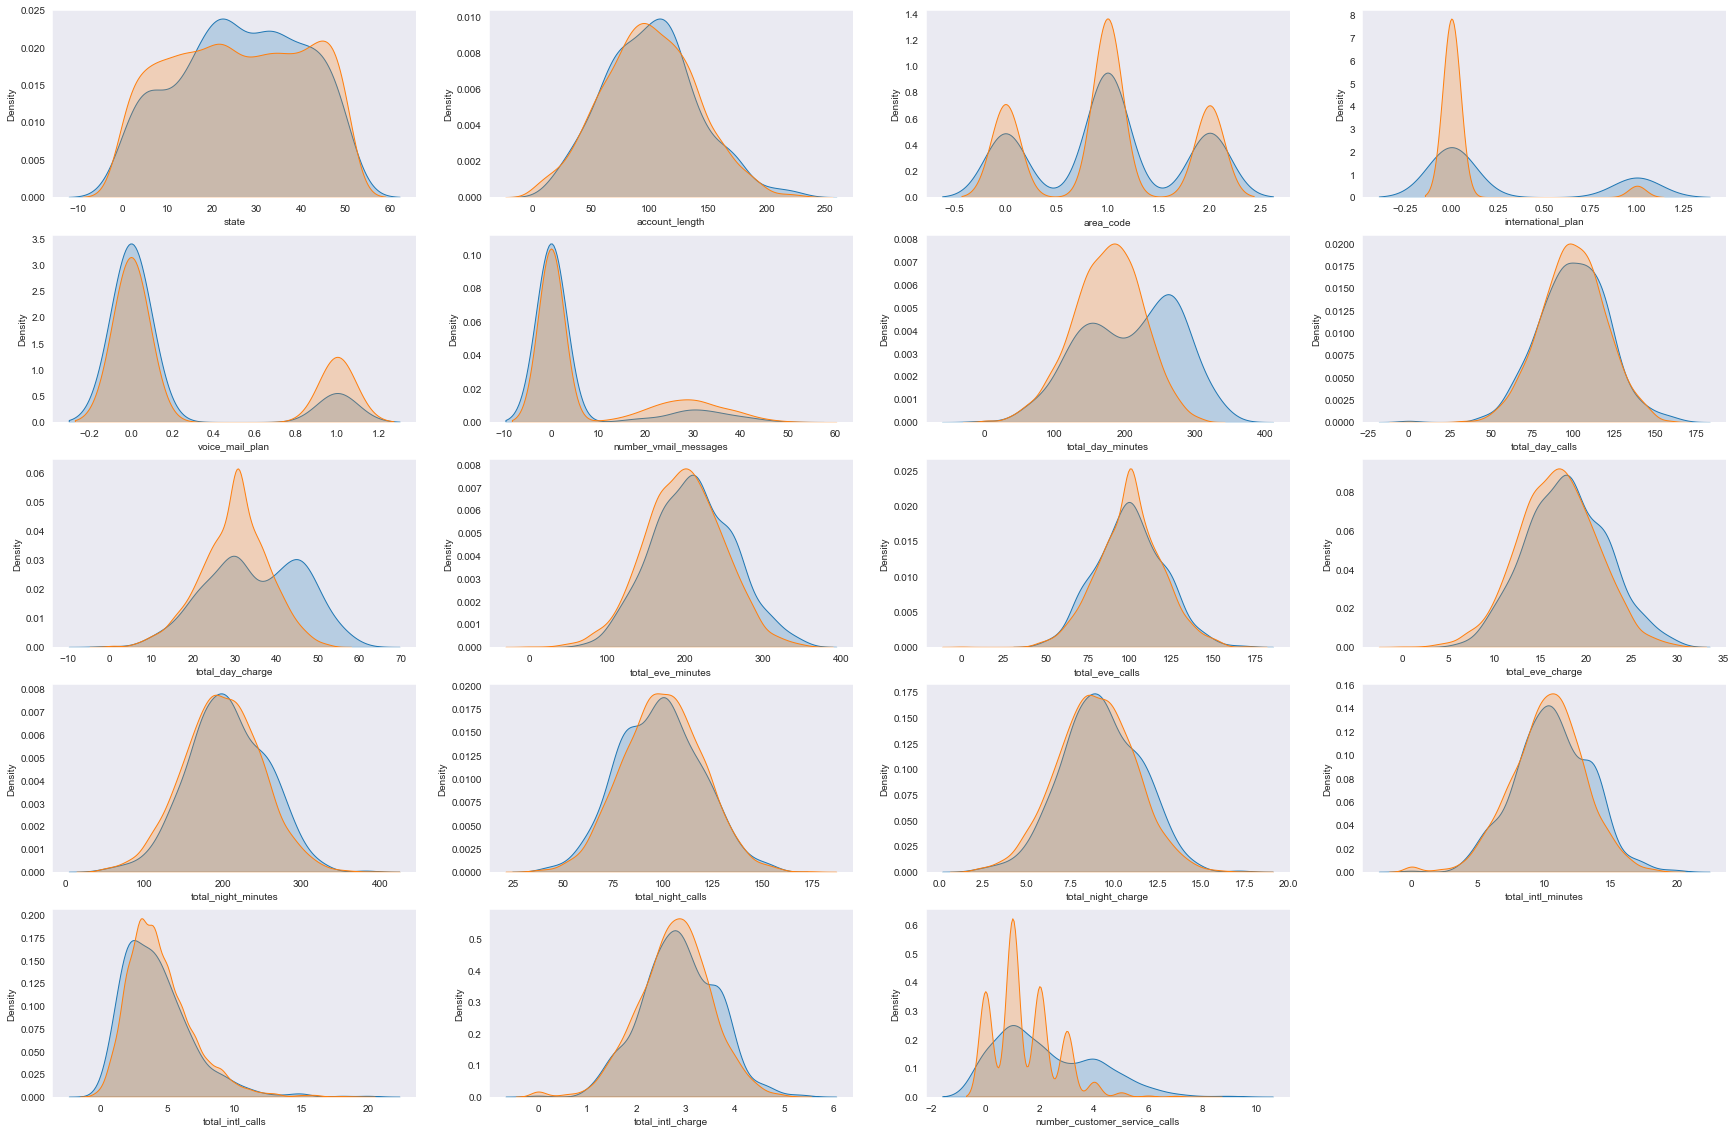

In [92]:
plt.figure(figsize=(30,20))
index = 1
for col in churn_data_train.columns:
    plt.subplot(5, 4, index)
    sns.kdeplot(data=churn_data_train[col][churn_data_train["churn"] == 1], shade=True)
    sns.kdeplot(data=churn_data_train[col][churn_data_train["churn"] == 0], shade=True)
    index += 1

## Build a churn prediction model


In [31]:
churn_features, churn_labels = get_features_labels_from_data(input_dataframe=churn_data_train, 
                                                             label_col="churn")

In [32]:
features_train, features_val, labels_train, labels_val = split_data_into_train_validation(churn_features, churn_labels)


In [309]:
param_grid = {
     'max_depth': [5, 10, 20],
     'learning_rate': [0.1, 0.01, 0.05],
     'gamma': [0, 0.25, 1.0],
     'reg_lambda': [0, 0.1, 0.5, 1.0],
     'scale_pos_weight': [1, 3, 5, 10]
}


optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                                          seed=42,
                                                          subsample=0.9,
                                                          colsample_bytree=0.5),
                              param_grid=param_grid,
                              scoring='roc_auc', 
                              verbose=0,
                              n_jobs = 10,
                              cv=3
                             );

optimal_params.fit(features_train, 
                    labels_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(features_val, labels_val)],
                    verbose=False);

print(optimal_params.best_params_)

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_en

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 20, 'reg_lambda': 0, 'scale_pos_weight': 10}


### Train XGBoost on Optimal Parameters

In [33]:
# Evaluate Optimized Model
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=5,
                        reg_lambda=0.5,
                        scale_pos_weight=10,
                        subsample=0.8,
                        colsample_bytree=0.5)

clf_xgb.fit(features_train, 
            labels_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(features_val, labels_val)])

[0]	validation_0-aucpr:0.45448
[1]	validation_0-aucpr:0.46893
[2]	validation_0-aucpr:0.54277
[3]	validation_0-aucpr:0.57551
[4]	validation_0-aucpr:0.60261
[5]	validation_0-aucpr:0.57438
[6]	validation_0-aucpr:0.63720
[7]	validation_0-aucpr:0.67748
[8]	validation_0-aucpr:0.67929
[9]	validation_0-aucpr:0.72733
[10]	validation_0-aucpr:0.75519
[11]	validation_0-aucpr:0.74361
[12]	validation_0-aucpr:0.73940
[13]	validation_0-aucpr:0.74991
[14]	validation_0-aucpr:0.77289
[15]	validation_0-aucpr:0.75927
[16]	validation_0-aucpr:0.75741
[17]	validation_0-aucpr:0.77377
[18]	validation_0-aucpr:0.76990
[19]	validation_0-aucpr:0.77922
[20]	validation_0-aucpr:0.78615
[21]	validation_0-aucpr:0.79302
[22]	validation_0-aucpr:0.79339
[23]	validation_0-aucpr:0.79806
[24]	validation_0-aucpr:0.80072
[25]	validation_0-aucpr:0.79731
[26]	validation_0-aucpr:0.79448
[27]	validation_0-aucpr:0.79529
[28]	validation_0-aucpr:0.79510
[29]	validation_0-aucpr:0.79294
[30]	validation_0-aucpr:0.79378
[31]	validation_0-

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.5, scale_pos_weight=10, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Plot train and validation ROC curve

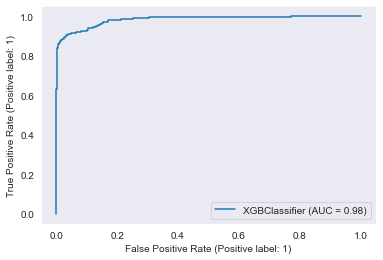

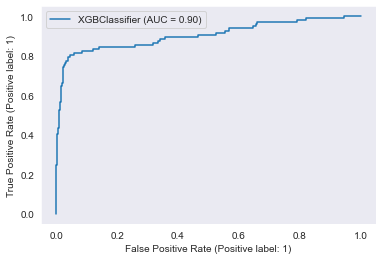

In [34]:
plot_roc_curve(clf_xgb, features_train, labels_train) 
plot_roc_curve(clf_xgb, features_val, labels_val) 
plt.legend()
plt.show()

In [46]:
print(classification_report(labels_val, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       603
           1       0.64      0.81      0.71        97

    accuracy                           0.91       700
   macro avg       0.80      0.87      0.83       700
weighted avg       0.92      0.91      0.91       700



## Prediction on validation set

In [35]:
predictions = clf_xgb.predict(features_val)

accuracy = (predictions == labels_val).sum().astype(float) / len(predictions)*100

print(f"XGBoost's prediction accuracy with optimal hyperparameters is: {accuracy:.3f} %")

XGBoost's prediction accuracy with optimal hyperparameters is: 91.000 %


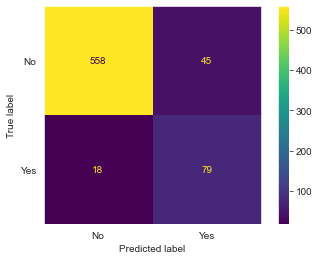

In [36]:
plot_confusion_matrix(clf_xgb, 
                      features_val, 
                      labels_val,
                      display_labels=["No", "Yes"]);

## Fine tuning the approach

### Check Correlation between different variables

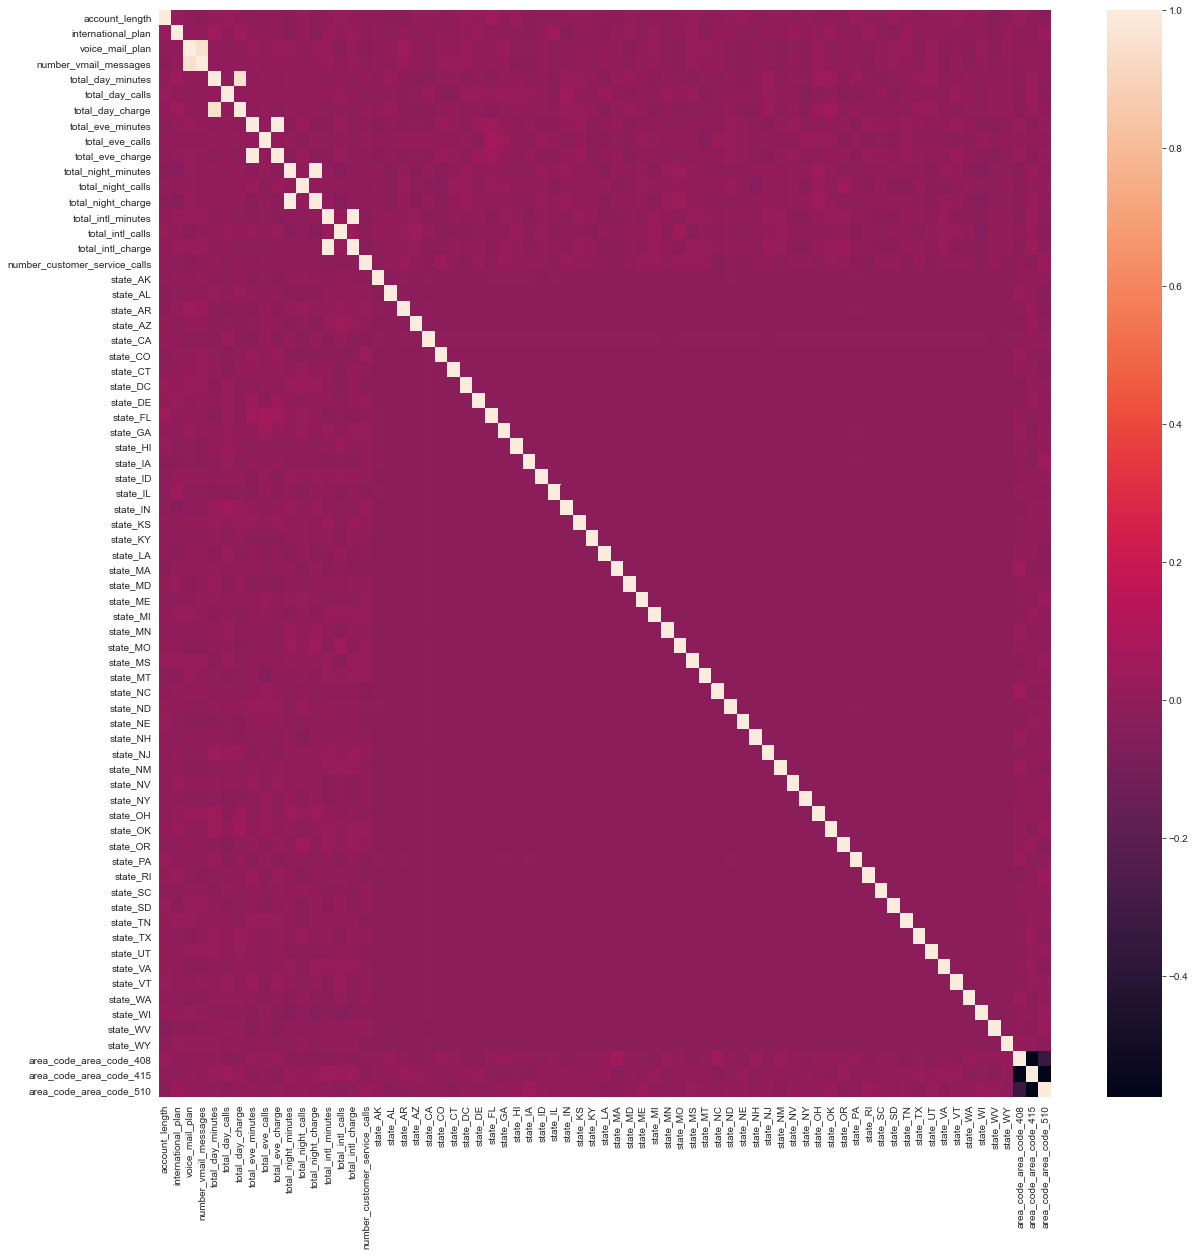

In [417]:
plt.figure(figsize = (20,20))
sns.heatmap(churn_features.corr());

### Delete the variables which has high correlation with other variables


In [38]:
# Create correlation matrix
corr_matrix = churn_features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
columns_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print("*** Columns to have higher correlation with other columns ***")
columns_to_drop

*** Columns to have higher correlation with other columns ***


['number_vmail_messages',
 'total_day_charge',
 'total_eve_charge',
 'total_night_charge',
 'total_intl_charge']

### Let's drop these columns, apply scaling and see if we get better performance

In [39]:
new_churn_features = drop_columns_from_dataframe(churn_features, columns_to_drop)

In [40]:
scaled_churn_features = scale_dataframe(new_churn_features, scale_type="standard")

In [41]:
new_features_train, new_features_val, new_labels_train, new_labels_val = split_data_into_train_validation(scaled_churn_features, 
                                                                                                          churn_labels)


### Train the model again

In [42]:
# Evaluate Optimized Model
new_clf_xgb = xgb.XGBClassifier(seed=42,
                                objective='binary:logistic',
                                gamma=1,
                                learning_rate=0.25,
                                max_depth=5,
                                reg_lambda=0,
                                scale_pos_weight=10,
                                subsample=0.8,
                                colsample_bytree=0.5)

new_clf_xgb.fit(new_features_train, 
                new_labels_train, 
                verbose=True, 
                early_stopping_rounds=10,
                eval_metric='aucpr',
                eval_set=[(new_features_val, new_labels_val)]
               )

[0]	validation_0-aucpr:0.51214
[1]	validation_0-aucpr:0.63250
[2]	validation_0-aucpr:0.59965
[3]	validation_0-aucpr:0.62595
[4]	validation_0-aucpr:0.62761
[5]	validation_0-aucpr:0.59771
[6]	validation_0-aucpr:0.62020
[7]	validation_0-aucpr:0.71953
[8]	validation_0-aucpr:0.72233
[9]	validation_0-aucpr:0.71660
[10]	validation_0-aucpr:0.72090
[11]	validation_0-aucpr:0.73275
[12]	validation_0-aucpr:0.73868
[13]	validation_0-aucpr:0.75019
[14]	validation_0-aucpr:0.74580
[15]	validation_0-aucpr:0.73267
[16]	validation_0-aucpr:0.72845
[17]	validation_0-aucpr:0.76352
[18]	validation_0-aucpr:0.76521
[19]	validation_0-aucpr:0.76777
[20]	validation_0-aucpr:0.76526
[21]	validation_0-aucpr:0.78344
[22]	validation_0-aucpr:0.79990
[23]	validation_0-aucpr:0.79748
[24]	validation_0-aucpr:0.79685
[25]	validation_0-aucpr:0.79451
[26]	validation_0-aucpr:0.79663
[27]	validation_0-aucpr:0.80380
[28]	validation_0-aucpr:0.80412
[29]	validation_0-aucpr:0.79942
[30]	validation_0-aucpr:0.79555
[31]	validation_0-

/Users/HarshP2/Downloads/Practice_Algorithm/Carta_DS_Challenge/v-env-python3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[58]	validation_0-aucpr:0.82829
[59]	validation_0-aucpr:0.82812
[60]	validation_0-aucpr:0.83150
[61]	validation_0-aucpr:0.83101
[62]	validation_0-aucpr:0.83009
[63]	validation_0-aucpr:0.83409
[64]	validation_0-aucpr:0.83352
[65]	validation_0-aucpr:0.83361
[66]	validation_0-aucpr:0.83193
[67]	validation_0-aucpr:0.83222
[68]	validation_0-aucpr:0.83190
[69]	validation_0-aucpr:0.83114
[70]	validation_0-aucpr:0.83300
[71]	validation_0-aucpr:0.83308
[72]	validation_0-aucpr:0.83247
[73]	validation_0-aucpr:0.83587
[74]	validation_0-aucpr:0.83585
[75]	validation_0-aucpr:0.83337
[76]	validation_0-aucpr:0.83394
[77]	validation_0-aucpr:0.83538
[78]	validation_0-aucpr:0.83822
[79]	validation_0-aucpr:0.83730
[80]	validation_0-aucpr:0.83690
[81]	validation_0-aucpr:0.83555
[82]	validation_0-aucpr:0.83667
[83]	validation_0-aucpr:0.83550
[84]	validation_0-aucpr:0.83743
[85]	validation_0-aucpr:0.83607
[86]	validation_0-aucpr:0.83557
[87]	validation_0-aucpr:0.83642


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=10, seed=42,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [43]:
new_predictions = new_clf_xgb.predict(new_features_val)

new_accuracy = (new_predictions == new_labels_val).sum().astype(float) / len(new_predictions)*100

print(f"XGBoost's prediction accuracy with optimal hyperparameters is: {new_accuracy:.3f} %")

XGBoost's prediction accuracy with optimal hyperparameters is: 95.143 %


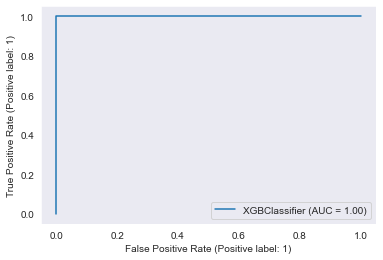

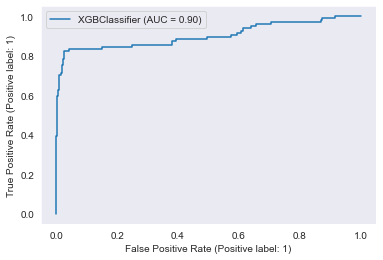

In [44]:
plot_roc_curve(new_clf_xgb, new_features_train, new_labels_train) 
plot_roc_curve(new_clf_xgb, new_features_val, new_labels_val) 
plt.legend()
plt.show()  

In [45]:
print(classification_report(new_labels_val, new_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       603
           1       0.84      0.80      0.82        97

    accuracy                           0.95       700
   macro avg       0.90      0.89      0.90       700
weighted avg       0.95      0.95      0.95       700



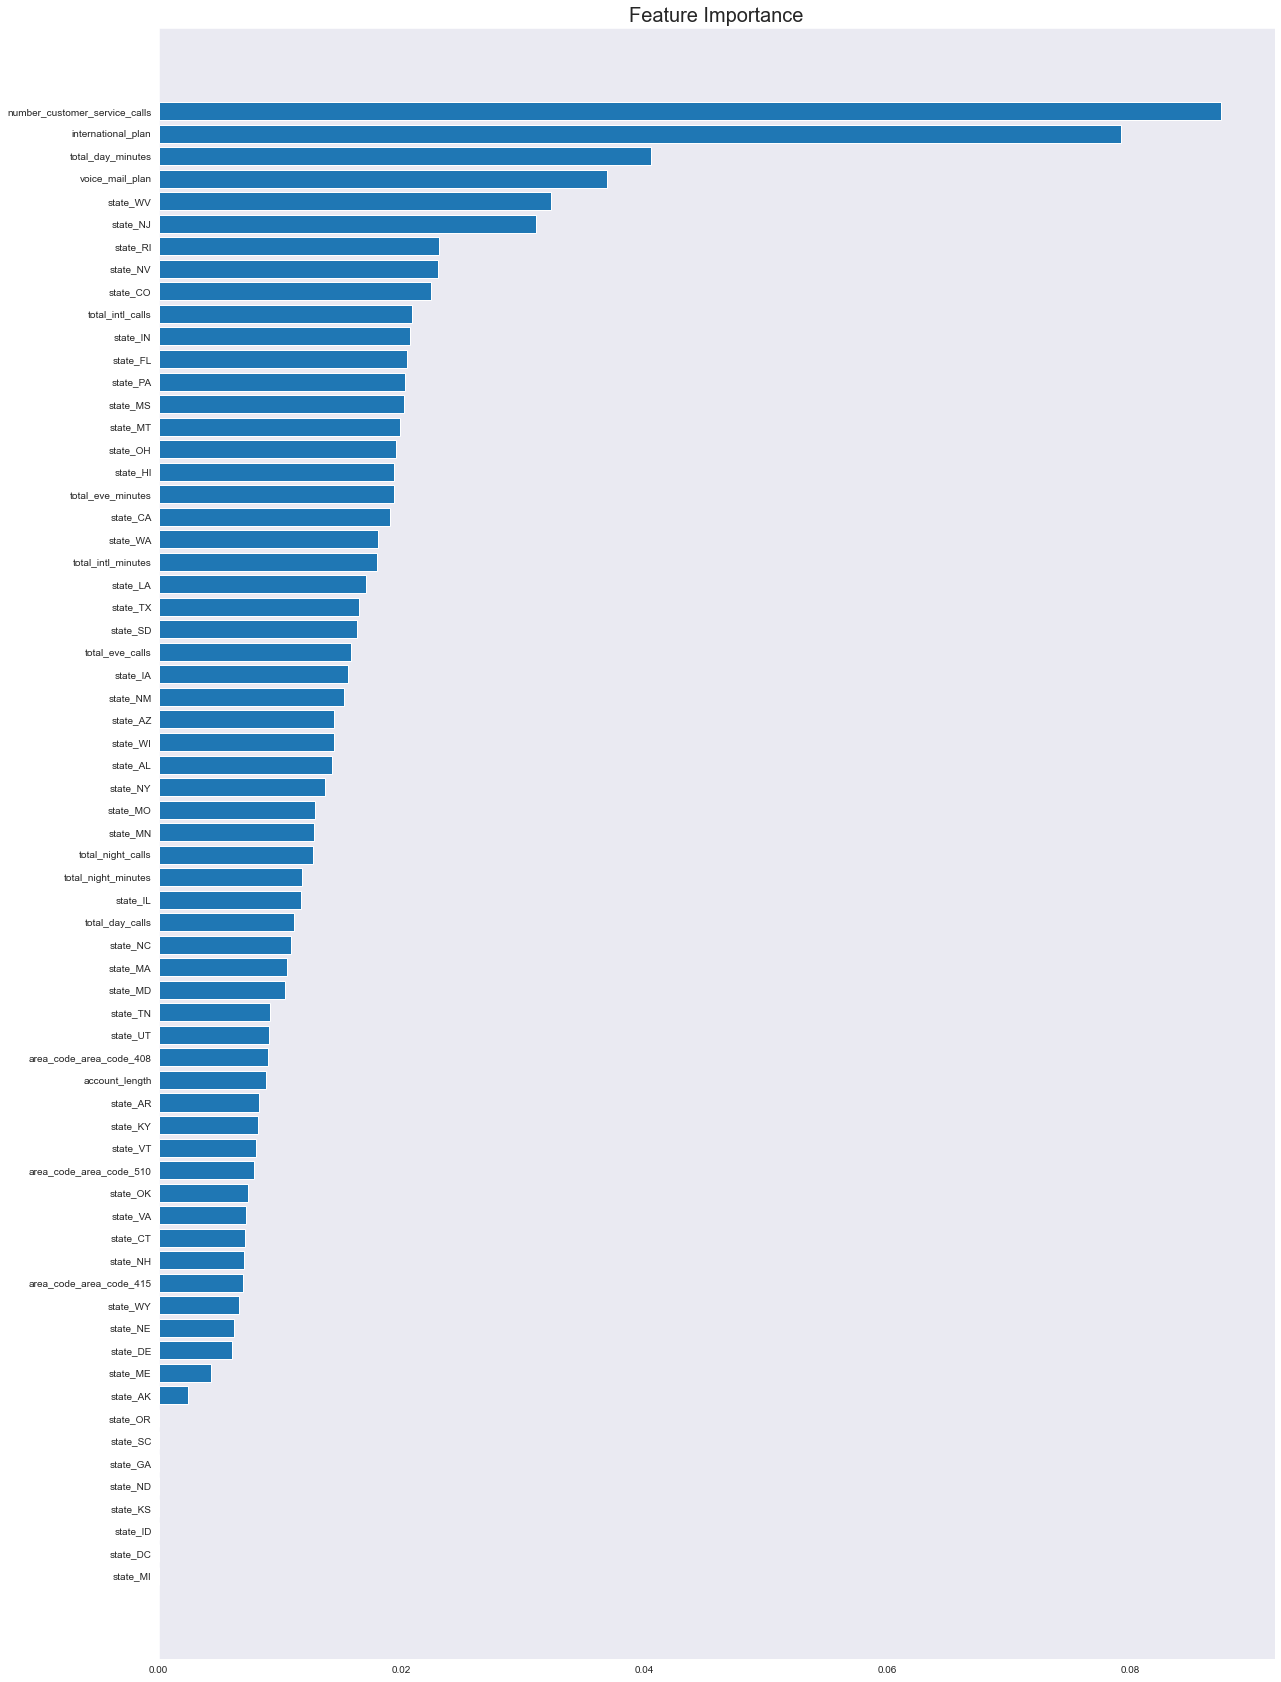

In [47]:
plt.figure(figsize = (20,30))

sorted_idx = new_clf_xgb.feature_importances_.argsort()
plt.barh(new_churn_features.columns[sorted_idx], new_clf_xgb.feature_importances_[sorted_idx])
plt.title("Feature Importance", fontsize=20);

### Let's run the model on our test dataset and capture the predictions

In [48]:
churn_test_features = drop_columns_from_dataframe(churn_data_test, columns_to_drop + ["index", "churn"])

In [49]:
NaN_columns = churn_test_features.columns[churn_test_features.isna().any()].tolist()
print(f"NaN columns: {NaN_columns}")

NaN columns: ['total_eve_calls']


### We found NULL values in one column. let's impute it based on train data

In [50]:
churn_test_features['total_eve_calls'].fillna(churn_data_train['total_eve_calls'].mean(), inplace=True)

## run predictions on test features and save them into a new column called churn 

In [51]:
test_predictions = new_clf_xgb.predict(churn_test_features)
test_predictions = np.where(test_predictions == 0,'no','yes')
churn_test_features["churn"] = test_predictions

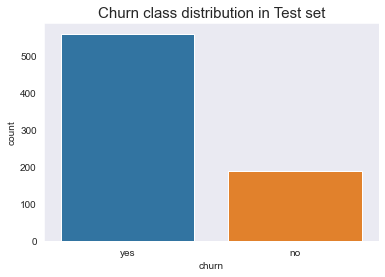

In [52]:
ax = sns.countplot(x='churn', data=churn_test_features);
ax.set_title("Churn class distribution in Test set", fontsize=15);

In [53]:
### Save predictions to file for submission

fileName = "predictions_churn_dataset_test.csv"
churn_test_features.to_csv(fileName, index=False)

print(f"File saved named: {fileName}..")

File saved named: predictions_churn_dataset_test.csv..
